In [1]:
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import glob

In [2]:
# 读取文件名的函数
def read_file(path, file_type):  # path 是指需要提取的文件夹所在路径;file_type是指文件的拓展名;txt格式的文件则输入‘.txt’
    filenames = os.listdir(path)
    filenames1 = []
    for filename in filenames:
        if os.path.splitext(filename)[1] == file_type:
            filenames1.append(filename)
    return filenames1

In [8]:
def mask_data(mask, masked_dt, LON, LAT, date, ii):
# def mask_data(mask, masked_dt, LON, LAT, date):
    reference_time = pd.Timestamp("now")
    da = xr.Dataset(
        {'imf': (("time","rows", "colms"), masked_dt)},
        coords=dict(
            time=date,
            lon=(['rows', "colms"], LON),
            lat=(["rows", "colms"], LAT),
            reference_time=reference_time,
        ),
        attrs=dict(
            description="IMFs from SMAPI",
            units="refer to the variable",
        ),  
        )
    da.to_netcdf('E:\\Data_inputs\\masked_data_HRB\\imfs'+str(ii)+'_HRB_from_1980_to_2021.nc')

In [4]:
os.chdir(r'E:\Data_inputs')  # 更改工作路径
curr_path = os.getcwd()  # 获取当前路径
files = read_file(curr_path, '.npy')  # 利用上述函数获取当前文件夹内的.nc文件名
path_file_number = glob.glob(pathname='*.npy')  # 获取当前文件夹下个数
smapi = xr.open_dataset('HRB_weekly_SMAPI.nc')

In [5]:
# 读取淮河流域掩膜
mask = xr.open_dataset(r'E:\mask_info\HuaiRiverBasin_HRB_001degree.nc') 
outline_spain = gpd.read_file(r'E:\shp\Huai_Edge\HRB_edge_polygon.shp')
#mask = mask.mask.values

In [9]:
lat = smapi.lat
lon = smapi.lon
LON,LAT = np.meshgrid(lon,lat)
date = smapi.time
for ii in range(len(files)):
    dt = np.load(files[ii])
    masked_dt = np.where(~np.isnan(mask.mask),dt, np.nan)
    mask_data(mask, masked_dt, LON, LAT, date)
    #mask_data(mask, masked_dt, LON, LAT, date,ii)
    print(ii)

0
1
2
3
4
5
6


In [10]:
smapi_dt = smapi['smapi'].values
masked_smapi = np.where(~np.isnan(mask.mask),smapi_dt, np.nan)
reference_time = pd.Timestamp("now")
da = xr.Dataset(
        {'smapi': (("time","rows", "colms"), masked_smapi)},
        coords=dict(
            time=date,
            lon=(['rows', "colms"], LON),
            lat=(["rows", "colms"], LAT),
            reference_time=reference_time,
        ),
        attrs=dict(
            description="SMAPI masked within HRB",
            units="refer to the variable",
        ),  
        )
da.to_netcdf('E:\\Data_inputs\\masked_data_HRB\\smapi'+'_HRB_from_1980_to_2021.nc')

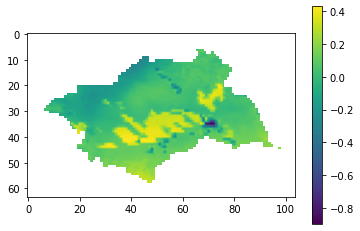

In [21]:
import matplotlib.pylab as plt
plt.imshow(masked_smapi[15,:,:])
plt.colorbar()


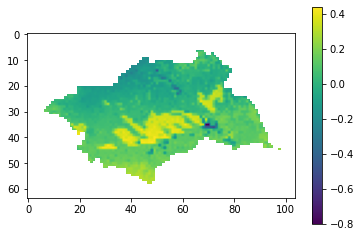

In [22]:
plt.imshow(masked_dt[15,:,:])
plt.colorbar()

In [35]:
os.chdir(r'E:\Data_inputs\masked_data_HRB')  # 更改工作路径
curr_path = os.getcwd()  # 获取当前路径
files = read_file(curr_path, '.nc')  # 利用上述函数获取当前文件夹内的.nc文件名


In [48]:
files

['imfs0_HRB_from_1980_to_2021.nc',
 'imfs1_HRB_from_1980_to_2021.nc',
 'imfs2_HRB_from_1980_to_2021.nc',
 'imfs3_HRB_from_1980_to_2021.nc',
 'imfs4_HRB_from_1980_to_2021.nc',
 'imfs5_HRB_from_1980_to_2021.nc',
 'imfs6_HRB_from_1980_to_2021.nc',
 'smapi_HRB_from_1980_to_2021.nc']

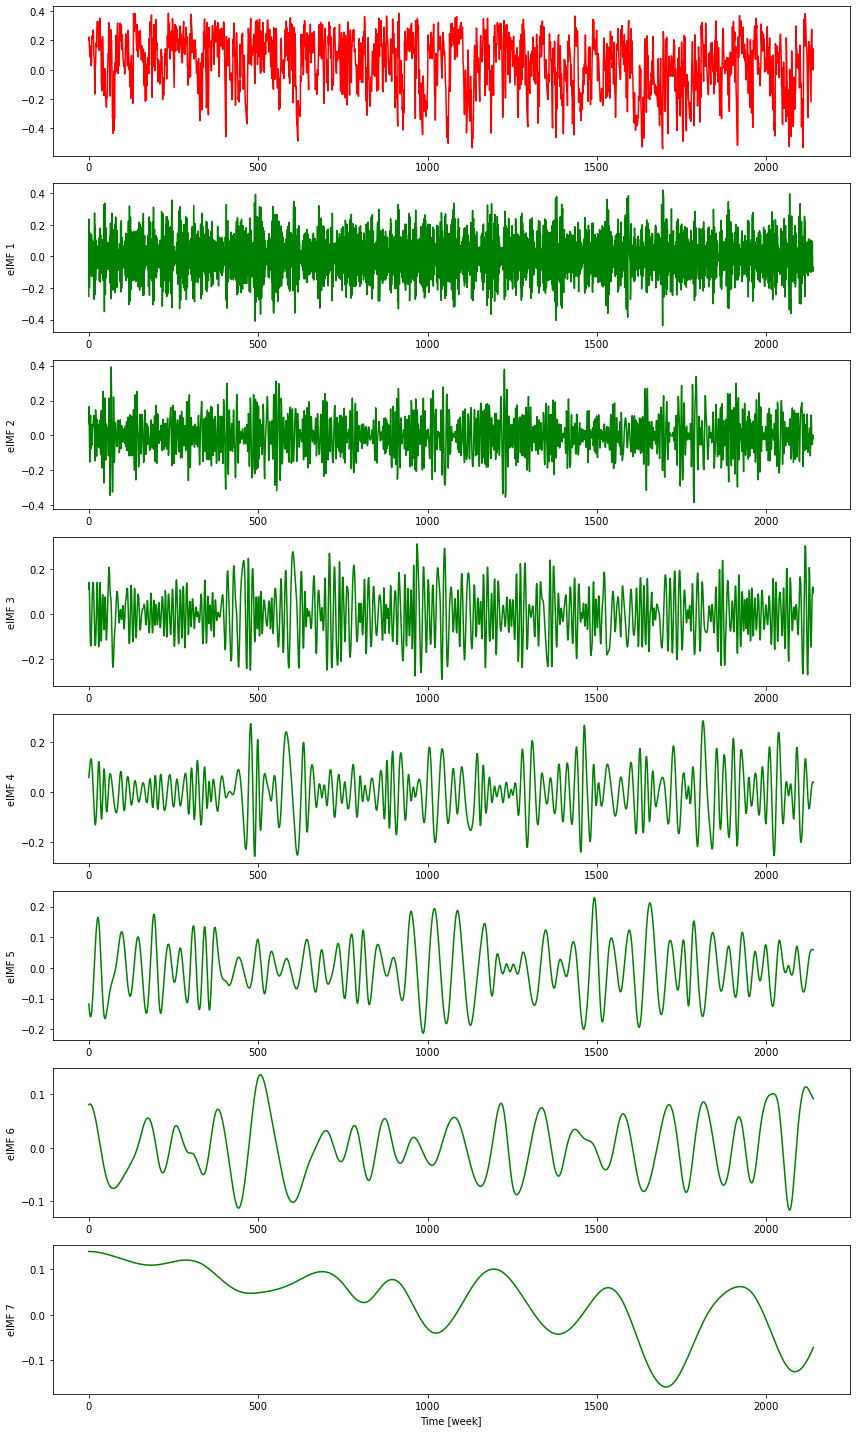

In [47]:
S = masked_smapi[:,45,30]
nIMFs = 7
plt.figure(figsize=(12,20))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(S, 'r')
#plt.xlim([0, 1])
for n in range(nIMFs):
    imf = xr.open_dataset(files[n]).imf
    eimf = imf[:,45,30]
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(eimf, 'g')
    if n == nIMFs:
       plt.ylabel("Residue (mean)")
    else:
        plt.ylabel("eIMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)
#     plt.xlim([0, 1])
plt.xlabel("Time [week]")
plt.tight_layout()

C:\Users\Xiaoyi Wang\AppData\Local\Temp\ipykernel_19548\2358008236.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  date = [pd.datetime(year=1979,month=12,day=31)+pd.Timedelta(weeks=i) for i in range(tspan)]


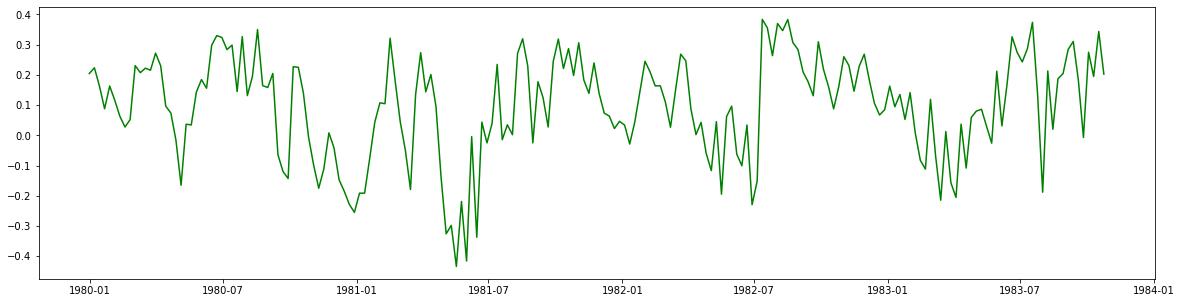

In [59]:
imf = xr.open_dataset(files[-1]).smapi
tspan = 200
eimf = imf[:tspan,45,30]
#plt.subplot(nIMFs+1, 1, n+2)
plt.figure(figsize=(20,5))
date = [pd.datetime(year=1979,month=12,day=31)+pd.Timedelta(weeks=i) for i in range(tspan)] 
plt.plot(date,eimf, 'g')

In [92]:
smapi.time[2043].values

array('2019-03-03', dtype='<U10')

C:\Users\Xiaoyi Wang\AppData\Local\Temp\ipykernel_19548\1190795889.py:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  date = [pd.datetime(year=2019,month=3,day=3)+pd.Timedelta(weeks=i) for i in range(t2-t1)]


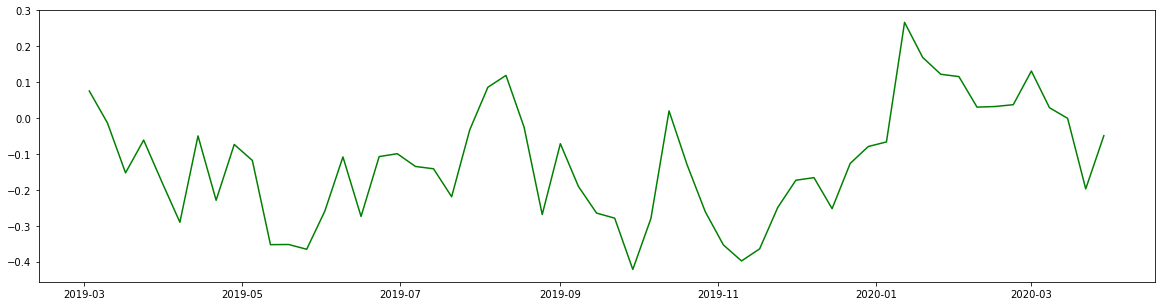

In [94]:
# 每日均值绘图
smi = xr.open_dataset(files[-1]).smapi.values
#smi_mean = np.nanmean(smi, axis=)
smi_mean = smi.reshape((smi.shape[0],-1))
smi_mean = np.nanmean(smi_mean, axis=1)
t1 = 2043
t2 = 2100
eimf = smi_mean[t1:t2]
plt.figure(figsize=(20,5))
date = [pd.datetime(year=2019,month=3,day=3)+pd.Timedelta(weeks=i) for i in range(t2-t1)] 
plt.plot(date,eimf, 'g')